# Surface Mass Balance 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

In [14]:
# Nils: Not needed??

from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set WD

In [3]:
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

**Load New Promice Data**

In [4]:
#Function for loading data and converting to datetime 
def load_promice(path_to_file):
    '''
    Loading PROMICE data for a given path into a DataFrame.
    + adding time index
    
    INTPUTS:
        path_to_file: Path to the desired file containing PROMICE data [string]
    
    OUTPUTS:
        df: Dataframe containing PROMICE data for the desired settings [DataFrame]
    '''

    df = pd.read_parquet(path_to_file, engine='pyarrow')
    df['time'] = pd.to_datetime(df.time, utc=True)
    df = df.set_index('time')
    return df




In [5]:
df = load_promice('data/new_promice/all_promice_data_hourly.parquet.gzip')

#### Load KM_L 

In [4]:
df = pd.read_csv('data/KAN_L.csv')

# add headers
header = pd.read_csv('metadata/promice_header.csv', sep = ";")
df = df.rename(columns = header.set_index('standard_name')['long_name'])

In [5]:
# Visual check on the usefulness of t the Ice Ablation periods

#....

In [6]:
# This bit to only focus on the time where we see Ice Ablation
df = df[df["Ablation"] == True]

**Exploration**

In [96]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.isna().sum(), columns = ["Sum of missing values"])
pd.set_option('display.max_rows', 5)

,Sum of missing values
air_pressure,4
air_temperature,4
relative_humidity,4
relative_humidity_corrected,4
specific_humidity,6
wind_speed,89
wind_from_direction,89
surface_downwelling_shortwave_flux,4
surface_downwelling_shortwave_flux_corrected,6
surface_upwelling_shortwave_flux,4


**Helper functions** (Nils: Can be removed?) 

In [8]:
#Function for writing to Markdown Report
def Msg(txt):
    f = open("out/Report.md", "a")
    print(txt)
    f.write(txt + "\n")

In [9]:
#For outlier detecttion and filter 
def hampel(vals_orig, k=7*24, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    #Make copy so original not edited
    vals=vals_orig.copy()    
    #Hampel Filter
    L= 1.4826
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    outlier_idx[0:round(k/2)]=False
    vals.loc[outlier_idx]=np.nan
    return(vals)

#### Correlation and Pairplot (takes long time to run for many variables)

In [10]:
df.columns

Index([                                        'index',
                                                'stid',
                                        'air_pressure',
                                     'air_temperature',
                                   'relative_humidity',
                         'relative_humidity_corrected',
                                   'specific_humidity',
                                          'wind_speed',
                                 'wind_from_direction',
                  'surface_downwelling_shortwave_flux',
        'surface_downwelling_shortwave_flux_corrected',
                    'surface_upwelling_shortwave_flux',
          'surface_upwelling_shortwave_flux_corrected',
                                      'surface_albedo',
                   'surface_downwelling_longwave_flux',
                     'surface_upwelling_longwave_flux',
                                 'cloud_area_fraction',
                                 'surface_temper

In [9]:
# This bit to plot only relevant columns
exclude_list = ["stid", "index", "Datetime", 'index',
                                                'stid',
                                   'relative_humidity',
                                   'specific_humidity',
                                 'wind_from_direction',
                  'surface_downwelling_shortwave_flux',
                    'surface_upwelling_shortwave_flux',
                   'surface_downwelling_longwave_flux',
                     'surface_upwelling_longwave_flux',
                   'surface_downward_latent_heat_flux',
                 'surface_downward_sensible_heat_flux',
                       'distance_to_surface_from_boom',
             'distance_to_surface_from_stake_assembly',
                 'depth_of_pressure_transducer_in_ice',
       'depth_of_pressure_transducer_in_ice_corrected',
                                       'precipitation',
                               'ice_temperature_at_t1',
                               'ice_temperature_at_t2',
                               'ice_temperature_at_t3',
                               'ice_temperature_at_t4',
                               'ice_temperature_at_t5',
                               'ice_temperature_at_t6',
                               'ice_temperature_at_t7',
                               'ice_temperature_at_t8',
                               'platform_view_angle_x',
                               'platform_view_angle_y',
                              'platform_azimuth_angle',
                                        'gps_latitude',
                                       'gps_longitude',
                                        'gps_altitude',
                                            'gps_time',
                                'gps_geoid_separation',
                                         'gps_geounit',
                                            'gps_hdop',
                                          'gps_numsat',
                                               'gps_q',
                                     'battery_voltage',
                     'battery_voltage_at_sample_start',
                                         'fan_current',
           'frequency_of_precipitation_wire_vibration',
                               'temperature_of_logger',
                     'temperature_of_radiation_sensor',
                # no entries for KAM_L
                                   'z_surf_1_adj_flag', 
                               'ice_temperature_at_t9',
                              'ice_temperature_at_t10',
                              'ice_temperature_at_t11',
                         'depth_of_ice_temperature_t9',
                        'depth_of_ice_temperature_t10',
                        'depth_of_ice_temperature_t11', 
               
               ]

exclude = df[[column for column in df.columns if column not in exclude_list and not isinstance(column, int)]]
exclude = exclude.dropna(axis=1,how='all') 

/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_37828/1896524193.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_37828/1896524193.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_37828/1896524193.py:14: DeprecationWarning: `np.bool` is a deprecated ali

<AxesSubplot:>

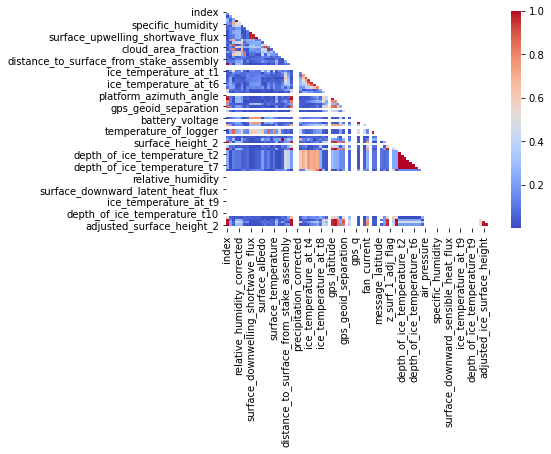

In [7]:
#sns.pairplot(data= exclude, hue="Ablation")
#sns.pairplot(data = exclude, kind='reg')

# Plot correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find the index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Generate a mask for the lower triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap of correlated columns
sns.heatmap(corr_matrix, cmap='coolwarm', mask=mask)

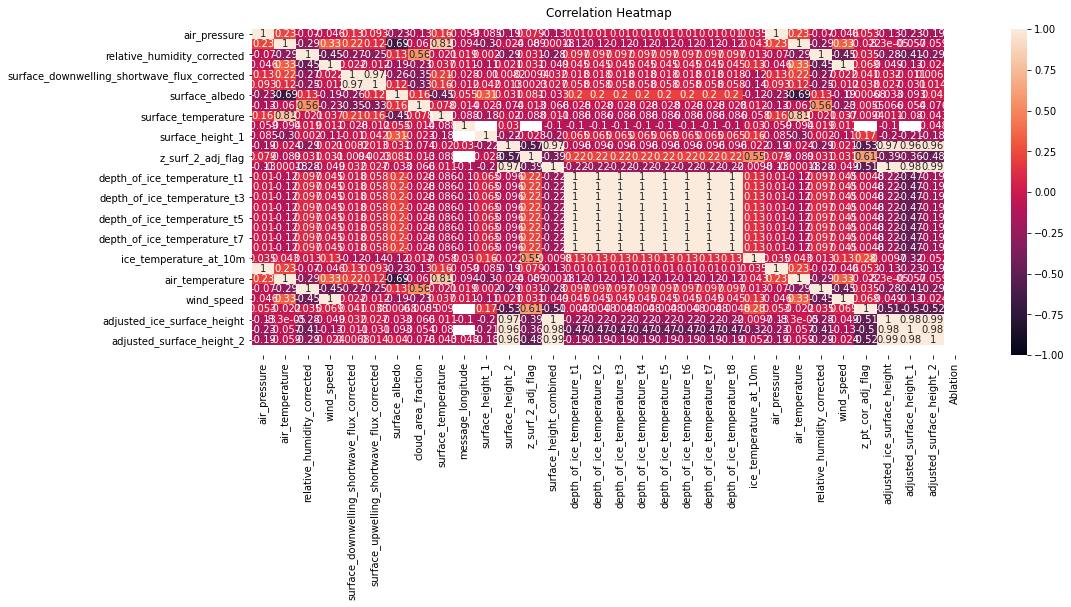

In [10]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(exclude.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Modelling

##### Pre-processing

In [11]:
# Change Ablation to binary
#df['Ablation'].replace(False, 0,inplace=True)
#df['Ablation'].replace(True, 1, inplace=True)

# A list of columns that are not considered relevant
exclude_list = [
                        "Ablation", # Since we only consider Ice Ablation periods anyways
                        'index', # Not needed
                        "stid", # Not needed for one Station
                        ## The following are not useful ##
                        'platform_azimuth_angle',
                        'gps_latitude',
                        'gps_longitude',
                        'gps_altitude',
                        'gps_time',
                        'gps_geoid_separation',
                        'gps_geounit',
                        'gps_hdop',
                        'gps_numsat',
                        'gps_q',
                        'battery_voltage',
                        'battery_voltage_at_sample_start',
                        'fan_current',
                        'frequency_of_precipitation_wire_vibration',
                        'temperature_of_logger',
                        'temperature_of_radiation_sensor',
                        ## The following have no entries for KAM_L ##
                        'z_surf_1_adj_flag', 
                        'ice_temperature_at_t9',
                        'ice_temperature_at_t10',
                        'ice_temperature_at_t11',
                        'depth_of_ice_temperature_t9',
                        'depth_of_ice_temperature_t10',
                        'depth_of_ice_temperature_t11', 
          ]

df = df[[column for column in df.columns if column not in exclude_list]]
df = df.dropna(axis=1,how='all') 

In [12]:
# This bit to change all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler

num_cols = df.select_dtypes(include=['int64','float64']).columns #select numerical columns

scaler = StandardScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [13]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

# Use CyclicalFeatures for the conversion
from feature_engine.creation import CyclicalFeatures

date_cols = df[['year', 'month','day', 'hour']].columns

# Create cyclical features
cyc_feat = CyclicalFeatures(drop_original=True)

#fit and transform numerical columns
df[date_cols] = scaler.fit_transform(df[date_cols])

In [32]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split

X= df.loc[:, df.columns != 'surface_height_combined'] # All features except y
y=df['surface_height_combined']

# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

In [33]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include=['int64','float64']).columns #select numerical columns

scaler = StandardScaler()

#fit and transform numerical columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

**PCA**

------------------------- With Imputation -----------------------------------------------------------------

In [97]:
# PCA does not allow missing values, we need to impute or exclude all NAN values..

# import the KNNimputer class
    #from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

# create an object for KNNImputer
    #imputer = KNNImputer(n_neighbors = 2)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.fit_transform(X_test)

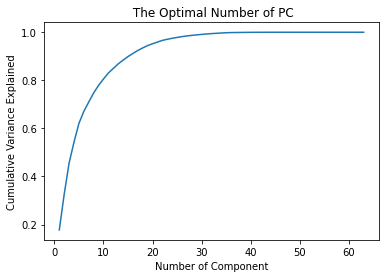

In [19]:
# Apply PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train_imp = pca.fit_transform(X_train_imp)
X_test_imp = pca.transform(X_test_imp)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()

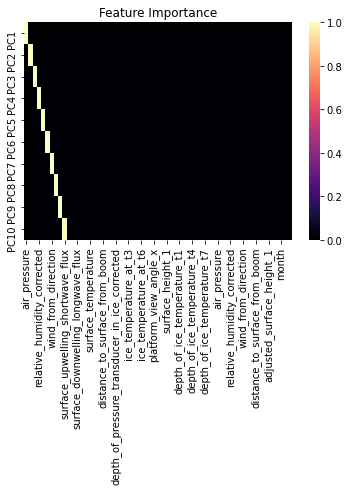

In [21]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.8) + 1

columns = [f'PC{i}' for i in range(1, optimal_component + 1)]

#Transform data with the optimal number of components
pca = PCA(n_components = optimal_component)

X_train_pca = pca.fit_transform(X_train_imp)
X_test_pca = pca.transform(X_test_imp)

# see how much features contribute to which components
pca_df = pd.DataFrame(pca.components_,
                      columns= X_train.columns,
                      index = columns)
pca_df.head()

#plot a heatmap to visualise how the feature variables contribute to PC
sns.heatmap(pca_df,cmap ='magma')
plt.title('Feature Importance')
plt.show()

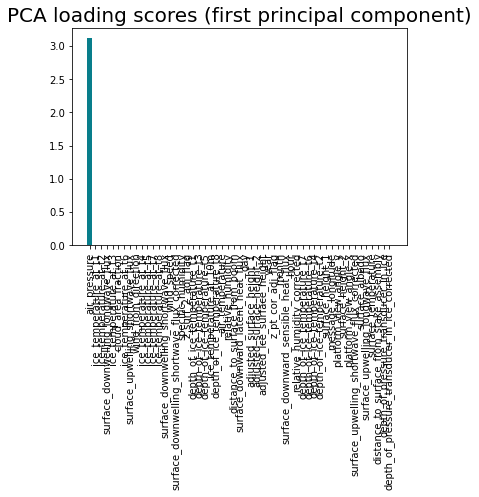

In [22]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns= columns ,
    index=  X_train.columns
)

pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

-------------------------------- Without Imputation ---------------------------------------------------

In [28]:
#  We can follow this paper: https://www.sciencedirect.com/science/article/pii/S1574954121000261#:~:text=The%20standard%20algorithm%20of%20PCA%20is%20modified%20to%20accommodate%20incomplete%20data.&text=The%20method%20produces%20ordination%20scores%20for%20variables%20and%20observations%20simultaneously.&text=Information%20is%20maximally%20exhausted%2C%20while%20data%20imputation%20is%20not%20required.
# Or: https://github.com/allentran/pca-magic

import os

import numpy as np
from scipy.linalg import orth


class PPCA():

    def __init__(self):

        self.raw = None
        self.data = None
        self.C = None
        self.means = None
        self.stds = None
        self.eig_vals = None

    def _standardize(self, X):

        if self.means is None or self.stds is None:
            raise RuntimeError("Fit model first")

        return (X - self.means) / self.stds

    def fit(self, data, d=None, tol=1e-4, min_obs=10, verbose=False):

        self.raw = data
        self.raw[np.isinf(self.raw)] = np.max(self.raw[np.isfinite(self.raw)])

        valid_series = np.sum(~np.isnan(self.raw), axis=0) >= min_obs

        data = self.raw[:, valid_series].copy()
        N = data.shape[0]
        D = data.shape[1]

        self.means = np.nanmean(data, axis=0)
        self.stds = np.nanstd(data, axis=0)

        data = self._standardize(data)
        observed = ~np.isnan(data)
        missing = np.sum(~observed)
        data[~observed] = 0

        # initial

        if d is None:
            d = data.shape[1]
        
        if self.C is None:
            C = np.random.randn(D, d)
        else:
            C = self.C
        CC = np.dot(C.T, C)
        X = np.dot(np.dot(data, C), np.linalg.inv(CC))
        recon = np.dot(X, C.T)
        recon[~observed] = 0
        ss = np.sum((recon - data)**2)/(N*D - missing)

        v0 = np.inf
        counter = 0

        while True:

            Sx = np.linalg.inv(np.eye(d) + CC/ss)

            # e-step
            ss0 = ss
            if missing > 0:
                proj = np.dot(X, C.T)
                data[~observed] = proj[~observed]
            X = np.dot(np.dot(data, C), Sx) / ss

            # m-step
            XX = np.dot(X.T, X)
            C = np.dot(np.dot(data.T, X), np.linalg.pinv(XX + N*Sx))
            CC = np.dot(C.T, C)
            recon = np.dot(X, C.T)
            recon[~observed] = 0
            ss = (np.sum((recon-data)**2) + N*np.sum(CC*Sx) + missing*ss0)/(N*D)

            # calc diff for convergence
            det = np.log(np.linalg.det(Sx))
            if np.isinf(det):
                det = abs(np.linalg.slogdet(Sx)[1])
            v1 = N*(D*np.log(ss) + np.trace(Sx) - det) \
                + np.trace(XX) - missing*np.log(ss0)
            diff = abs(v1/v0 - 1)
            if verbose:
                print(diff)
            if (diff < tol) and (counter > 5):
                break

            counter += 1
            v0 = v1


        C = orth(C)
        vals, vecs = np.linalg.eig(np.cov(np.dot(data, C).T))
        order = np.flipud(np.argsort(vals))
        vecs = vecs[:, order]
        vals = vals[order]

        C = np.dot(C, vecs)

        # attach objects to class
        self.C = C
        self.data = data
        self.eig_vals = vals
        self._calc_var()

    def transform(self, data=None):

        if self.C is None:
            raise RuntimeError('Fit the data model first.')
        if data is None:
            return np.dot(self.data, self.C)
        return np.dot(data, self.C)

    def _calc_var(self):

        if self.data is None:
            raise RuntimeError('Fit the data model first.')

        data = self.data.T

        # variance calc
        var = np.nanvar(data, axis=1)
        total_var = var.sum()
        self.var_exp = self.eig_vals.cumsum() / total_var

    def save(self, fpath):

        np.save(fpath, self.C)
        
    def load(self, fpath):

        assert os.path.isfile(fpath)

        self.C = np.load(fpath)

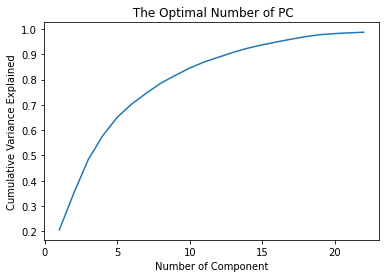

In [41]:
ppca = PPCA()

ppca.fit(data = X_train.to_numpy(), d=30)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = ppca.var_exp
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()


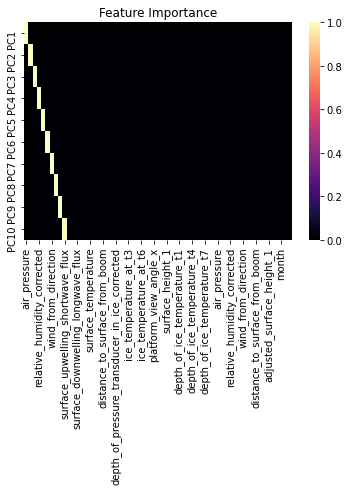

In [50]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.8) + 1

columns = [f'PC{i}' for i in range(1, optimal_component + 1)]

ppca = PPCA()

X_train_ppca = ppca.fit(data = X_train.to_numpy(), d=optimal_component) 
X_train_ppca = ppca.transform(X_train_ppca)
X_test_ppca = ppca.transform(X_test.to_numpy())

# see how much features contribute to which components
ppca_df = pd.DataFrame(ppca.C,
                       columns = columns,
                       index =X_train.columns)
ppca_df.head()

#plot a heatmap to visualise how the feature variables contribute to PC
sns.heatmap(pca_df,cmap ='magma')
plt.title('Feature Importance')
plt.show()

In [26]:
## Nils: Can be removed??

# import necessary libraries 
import pandas as pd
from sklearn.decomposition import ProbabilisticPCA
import matplotlib.pyplot as plt


columns = [f'PC{i}' for i in range(1, optimal_component + 1)]

# extract components 
eigenvalues = pca.eigenvalues_
components = pca.components_

X_train_ppca = ppca.fit(X_train.to_numpy(), d = optimal_component)
X_train_ppca = ppca.transform(X_train_ppca)
X_test_ppca = ppca.transform(X_test.to_numpy())

# see how much features contribute to which components
ppca_df = pd.DataFrame(ppca.C,
                       columns = columns,
                       index =X_train.columns)
ppca_df.head()

#plot a heatmap to visualise how the feature variables contribute to PC
sns.heatmap(pca_df,cmap ='magma')
plt.title('Feature Importance')
plt.show()

AttributeError: 'PCA' object has no attribute 'eigenvalues_'

In [47]:
## Nils: Can be removed??

#importing relevant libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import mixture

# Conducting Probabilistic Principal Component Analysis
ppca = mixture.BayesianGaussianMixture(n_components = 2, covariance_type = "full", tol = 0.0001, max_iter = 500).fit(X)

# Extracting the Proabaility distribution 
x_mean = ppca.means_ 
x_var = ppca.covariances_


ValueError: Input X contains NaN.
BayesianGaussianMixture does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**XGB Regression**

In [83]:
from xgboost import XGBRegressor

model = XGBRegressor()

X_train = X_train.loc[:,~X_train.columns.duplicated()]
model.fit(X_train, y_train)

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

In [84]:
importances

,Attribute,Importance
46,adjusted_ice_surface_height,0.943
21,depth_of_pressure_transducer_in_ice_corrected,0.055
20,depth_of_pressure_transducer_in_ice,0.002
19,distance_to_surface_from_stake_assembly,0.000
36,depth_of_ice_temperature_t1,0.000
34,surface_height_2,0.000
48,adjusted_surface_height_2,0.000
26,ice_temperature_at_t5,0.000
50,month,0.000
33,surface_height_1,0.000


**Linear Regression**

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

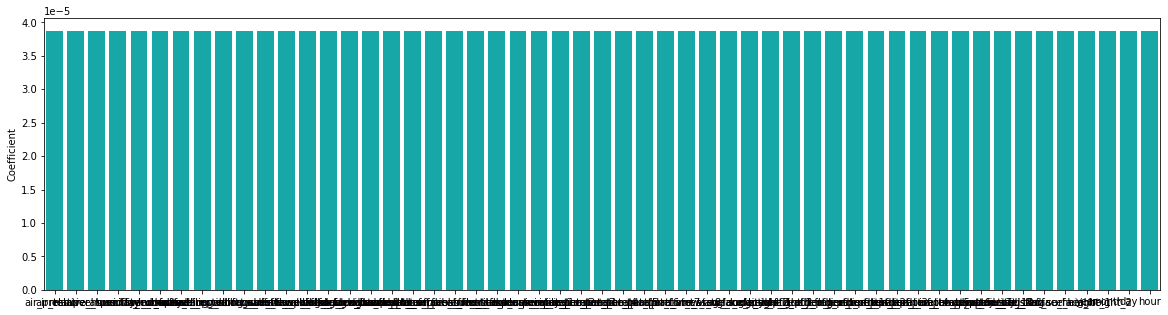

In [101]:
#import linear regression model from scikit-learn library
from sklearn.linear_model import LinearRegression

#import libraries for visualization
import matplotlib as mp

#instantiate the LinearRegression model 
lm = LinearRegression()

#fit the model to our data
lm.fit(X_train_imp,y_train)

#obtain the coefficients 
coefficients = pd.DataFrame({'Coefficient':lm.coef_[0]}, index=X_train.columns)

#visualize the coefficients 
plt.figure(figsize=(20,5))
sns.barplot(x=coefficients.index, y="Coefficient",data=coefficients,
            color="c")
plt.xticks

**KNN Regression**

In [85]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)



ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values